# FBM - Milo analysis

**Author:** Emma Dann / **Date:** 27/01/2021

Borrowing heavily from https://github.com/MarioniLab/milo_analysis_2020/blob/master/notebooks/milo_in_python.ipynb

In [48]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt 
import seaborn as sns

r2py setup

In [2]:
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging

In [3]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

Activate the anndata2ri conversion between SingleCellExperiment and AnnData

In [4]:
anndata2ri.activate()

Loading the `rpy2` extension enables cell magic to be used. This runs R code in jupyter notebook cells.

In [5]:
%load_ext rpy2.ipython

Install the R package from github. 

In [7]:
%%R
library(miloR)
library(igraph)
library(dplyr)
library(purrr)

### Load dataset

In [8]:
adata = sc.read("/nfs/team205/ed6/data/fbm4Simone/fbm_ds_combined_20210119.h5ad")

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/compat/__init__.py:182: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/compat/__init__.py:182: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


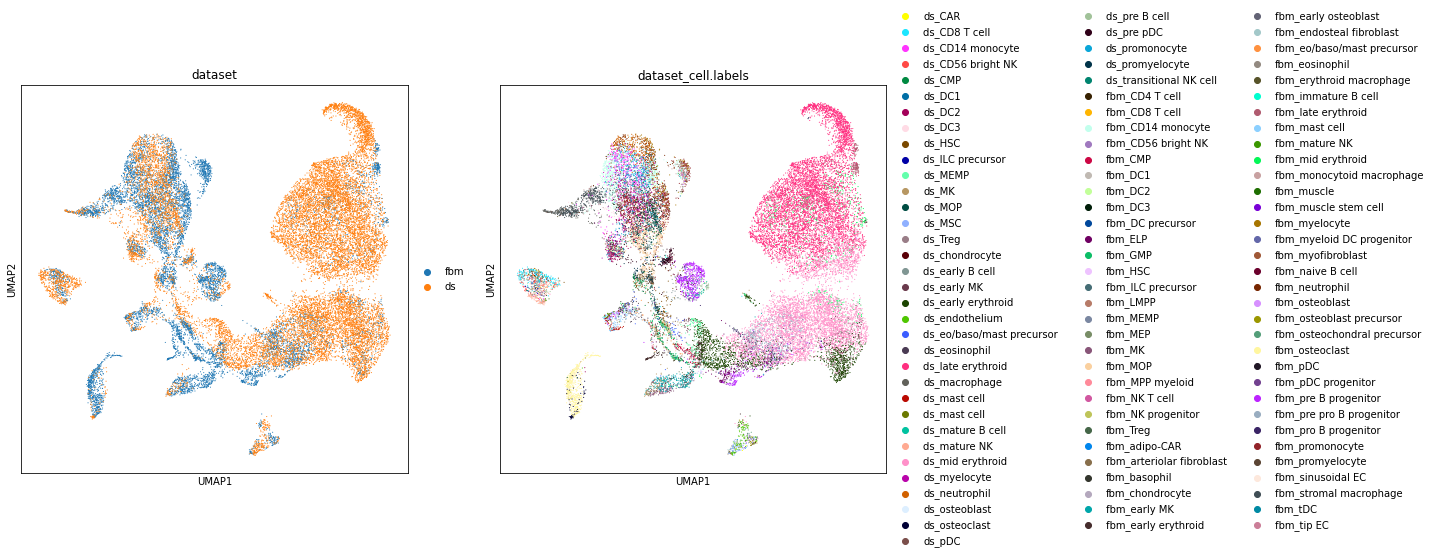

In [9]:
plt.rcParams["figure.figsize"] = [7,7]
sc.pl.umap(adata, color=["dataset", 'dataset_cell.labels'])

### Make Milo object

To start with, we have to convert our anndata object back into a SingleCellExperiment. The `anndata2ri` converter doesn't seem to like converting anndata objects storing the KNN graph in the `adata.obsp` slot, probably because there is no dedicated slot in the `SingleCellExperiment` object. Because of this, we will first make a copy of our `anndata` without KNN graph for conversion.

In [10]:
adata_no_knn = adata.copy()
adata_no_knn.obsp = None
adata_no_knn.uns.pop("neighbors")
adata_no_knn

AnnData object with n_obs × n_vars = 26460 × 33712
    obs: '__is_in_cluster__', 'age', 'april_cell.labels', 'auto_prd', 'batch', 'cell.labels', 'cell.labels_20200708', 'cell.labels_20200713', 'cell.labels_20200718', 'dataset', 'doublets', 'fetal.ids', 'gender', 'is_doublet', 'is_doublet_poptrim', 'is_doublet_wolock', 'lanes', 'leiden', 'lr_pred', 'mad_prd', 'mito.threshold', 'nGene', 'nUMI', 'n_genes', 'nk_meta', 'orig.ident', 'percent.mito', 'processing.type', 'scrublet_cluster_score', 'scrublet_score', 'sequencing.type', 'sex', 'sort.ids', 'souporcell_assignment', 'souporcell_doublet', 'dataset_cell.labels', 'broad_cell.labels'
    var: 'gene_ids-1-fbm', 'feature_types-1-fbm', 'gene_ids-0-ds', 'gene_ids-1-ds', 'highly_variable-1-ds', 'means-1-ds', 'dispersions-1-ds', 'dispersions_norm-1-ds', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'broad_cell.labels_colors', 'cell.labels_colors', 'dataset_colors', 'orig.ident_colors', 'pca', 'sequencing.type_colors', '

This can be converted to a `SingleCellExperiment` using R magic again

In [11]:
%%R -i adata_no_knn
adata_no_knn

class: SingleCellExperiment 
dim: 33712 26460 
metadata(7): broad_cell.labels_colors cell.labels_colors ...
  sequencing.type_colors dataset_cell.labels_colors
assays(1): X
rownames(33712): RP11-34P13.3 RP11-34P13.7 ... CTB-58E17.2
  RP5-1077H22.1
rowData names(12): gene_ids.1.fbm feature_types.1.fbm ... dispersions
  dispersions_norm
colnames(26460):
  F38_boneMarrow_CD45+_FCAImmP7528281_3prime_AACCGCGAGACTGGGT
  F38_boneMarrow_CD45+_FCAImmP7528281_3prime_AACTCCCCAATGTAAG ...
  TTTGTCATCAAGGCTT-1-DSOX19 TTTGTCATCGCTGATA-1-DSOX19
colData names(37): X__is_in_cluster__ age ... dataset_cell.labels
  broad_cell.labels
reducedDimNames(3): X_orig_pca PCA UMAP
altExpNames(0):


In [12]:
%%R 
milo <- Milo(adata_no_knn)
milo

class: Milo 
dim: 33712 26460 
metadata(7): broad_cell.labels_colors cell.labels_colors ...
  sequencing.type_colors dataset_cell.labels_colors
assays(1): X
rownames(33712): RP11-34P13.3 RP11-34P13.7 ... CTB-58E17.2
  RP5-1077H22.1
rowData names(12): gene_ids.1.fbm feature_types.1.fbm ... dispersions
  dispersions_norm
colnames(26460):
  F38_boneMarrow_CD45+_FCAImmP7528281_3prime_AACCGCGAGACTGGGT
  F38_boneMarrow_CD45+_FCAImmP7528281_3prime_AACTCCCCAATGTAAG ...
  TTTGTCATCAAGGCTT-1-DSOX19 TTTGTCATCGCTGATA-1-DSOX19
colData names(37): X__is_in_cluster__ age ... dataset_cell.labels
  broad_cell.labels
reducedDimNames(3): X_orig_pca PCA UMAP
altExpNames(0):
nhoods dimensions(2): 1 1
nhoodCounts dimensions(2): 1 1
nhoodDistances dimension(1): 0
graph names(0):
nhoodIndex names(1): 0
nhoodExpression dimension(2): 1 1
nhoodReducedDim names(0):
nhoodGraph names(0):
nhoodAdjacency dimension(2): 1 1


### Add KNN graph

Use same params used for UMAP

In [13]:
# ## Save the binary connectivity matrix
# knn_adjacency = adata.obsp["connectivities"]

In [14]:
k = adata.uns["neighbors"]["params"]["n_neighbors"]
d = adata.uns["neighbors"]["params"]["n_components"]

In [36]:
%%R -i d -i k
milo <- buildGraph(milo, k=k, d=d, reduced.dim = "PCA")

#### Run Milo analysis

Now we are all set to run the different steps of the Milo analysis in our R chunks. Let's start by defining our design matrix. Here we are going to test for DA between cells in stage E6.5 and stage E7.25, while controlling for the sequencing batch

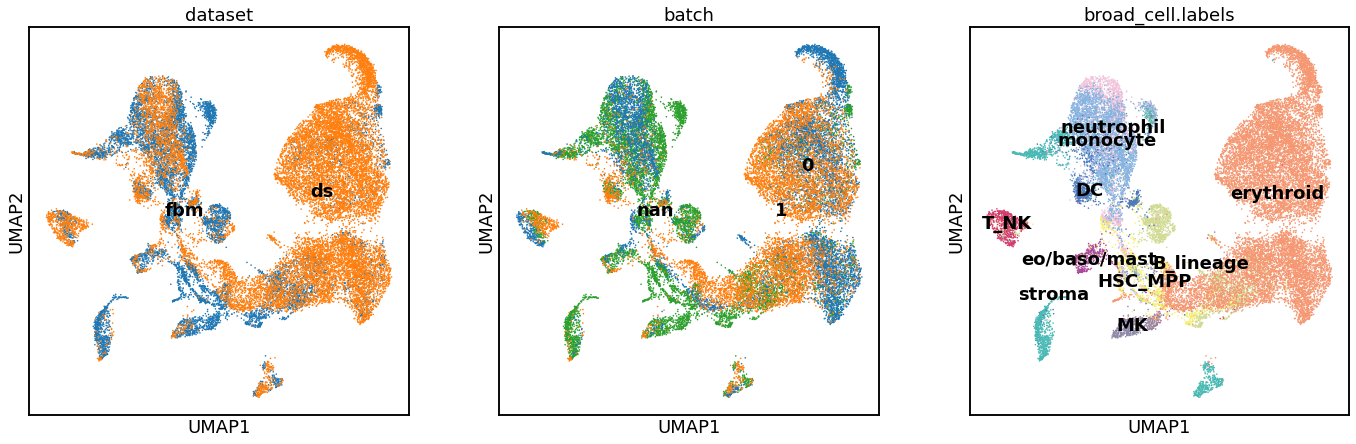

In [53]:
sc.pl.umap(adata, color=["dataset","batch","broad_cell.labels"], legend_loc="on data", size=10)

In [17]:
design_df = adata.obs[["lanes","dataset"]]
design_df.drop_duplicates(inplace=True)
design_df.index = design_df['lanes']
design_df

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,lanes,dataset
lanes,,
FCAImmP7528281,FCAImmP7528281,fbm
FCAImmP7528282,FCAImmP7528282,fbm
FCAImmP7579232,FCAImmP7579232,fbm
FCAImmP7579233,FCAImmP7579233,fbm
FCAImmP7579220,FCAImmP7579220,fbm
FCAImmP7579221,FCAImmP7579221,fbm
DSOX4,DSOX4,ds
DSOX7,DSOX7,ds
DSOX8,DSOX8,ds


Then we just copy the steps from the package vignettes. Again, we need to give the design dataframe in input to the R chunk, and ask for the dataframe storing differential abundance results as output. I use the same parameters used for KNN graph building (number of dimensions and k).

In [95]:
%%R -i design_df  -o DA_results
## Define neighbourhoods
milo <- makeNhoods(milo, prop = 0.05, k = k, d=d, reduced_dims = "PCA")

In [96]:
%%R -i design_df  -o DA_results
## Count cells in neighbourhoods
milo <- countCells(milo, meta.data = data.frame(colData(milo)), sample="lanes")

## Calculate distances between cells in neighbourhoods
## for spatial FDR correction
milo <- calcNhoodDistance(milo, d=d)

In [122]:
%%R -i design_df  -o DA_results
## Test for differential abundance
DA_results <- testNhoods(milo, design = ~ 0 + dataset, design.df = design_df, model.contrasts="datasetfbm-datasetds")

### Check test stats

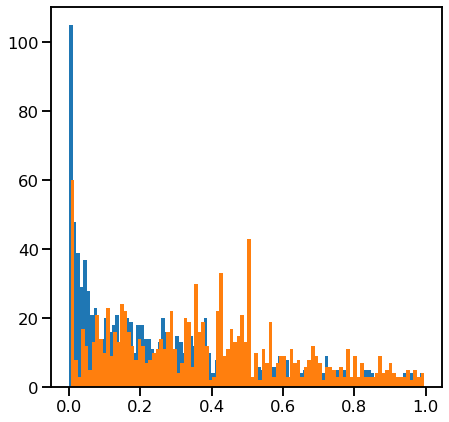

In [123]:
plt.hist(DA_results.PValue, bins=100);
plt.hist(DA_results.SpatialFDR, bins=100);

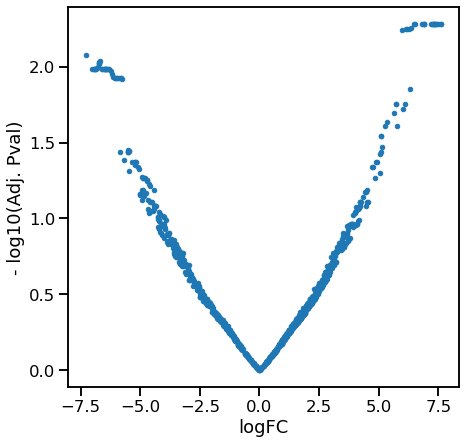

In [124]:
sns.set_context("talk")
plt.plot(DA_results.logFC, -np.log10(DA_results.SpatialFDR),'.');
plt.xlabel("logFC");
plt.ylabel("- log10(Adj. Pval)");

## Visualize DA results on graph

In [118]:
%%R
milo <- buildNhoodGraph(milo)

To visualize the graph, you have again multiple options. The first one is to just use the functionalities implemented in the `miloR` package in another R chunk.

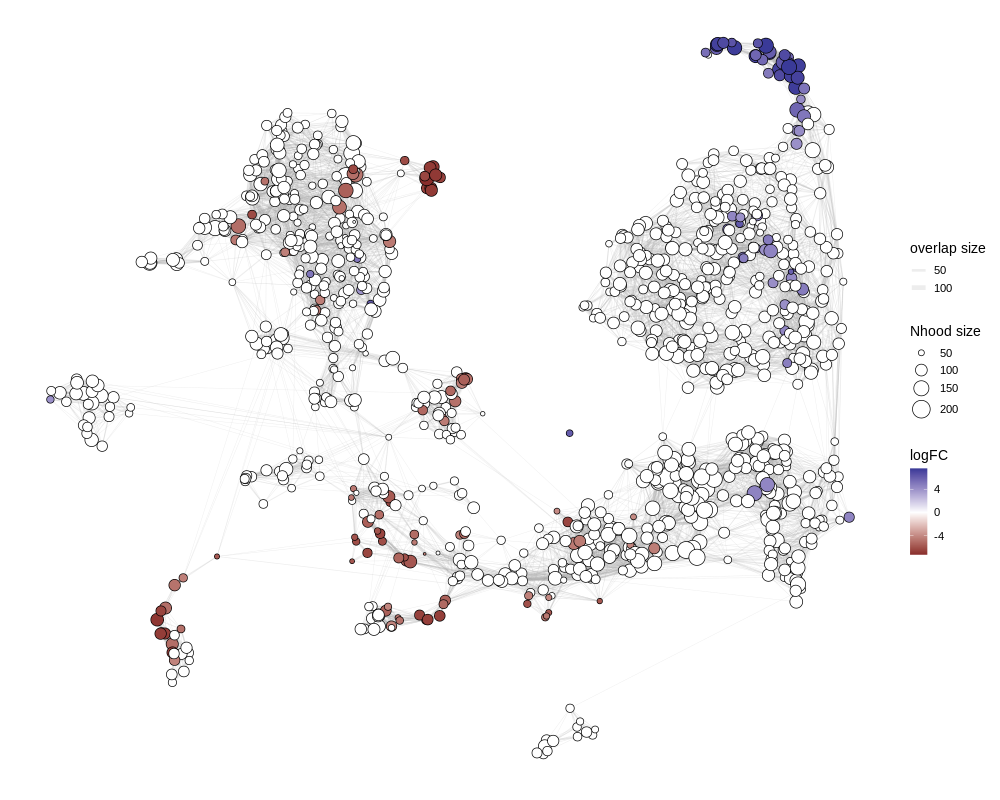

In [125]:
%%R -w 1000 -h 800
plotNhoodGraphDA(milo, DA_results, alpha=0.1) +
scale_size(range = c(1,8), name="Nhood size") 

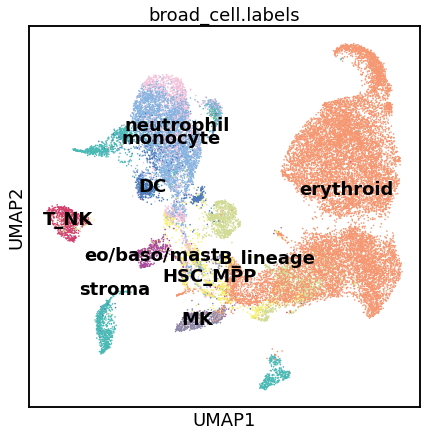

In [108]:
sc.pl.umap(adata, color=["broad_cell.labels"], legend_loc="on data", size=10)

## Visualize DA results by cell type

I assign a label to each neighbourhood based on the most abundant cell label. To visualize results I filter neighbourhoods with uniform labels (at least 60% cells with the assigned label) 

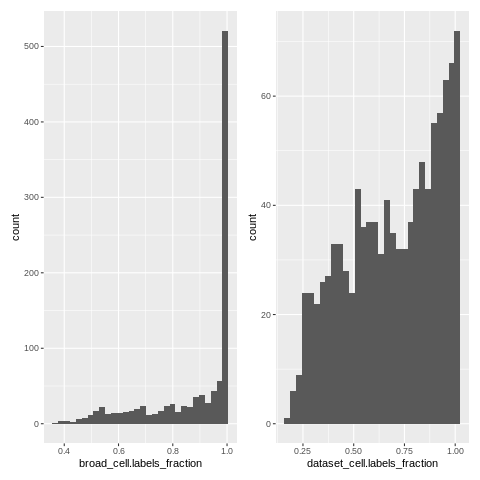

In [126]:
%%R
library(ggplot2)
library(patchwork)
DA_results <- annotateNhoods(milo, DA_results, "broad_cell.labels")
DA_results <- annotateNhoods(milo, DA_results, 'dataset_cell.labels')
DA_results %>%
    ggplot(aes(broad_cell.labels_fraction)) + geom_histogram() +
DA_results %>%
    ggplot(aes(dataset_cell.labels_fraction)) + geom_histogram()

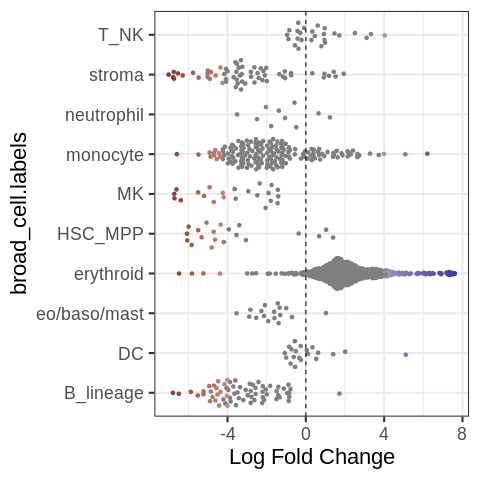

In [128]:
%%R
plotDAbeeswarm(DA_results, group.by="broad_cell.labels", alpha=0.1,subset.nhoods=DA_results[['broad_cell.labels_fraction']] > 0.6) +
geom_hline(yintercept=0, linetype=2, color="black")

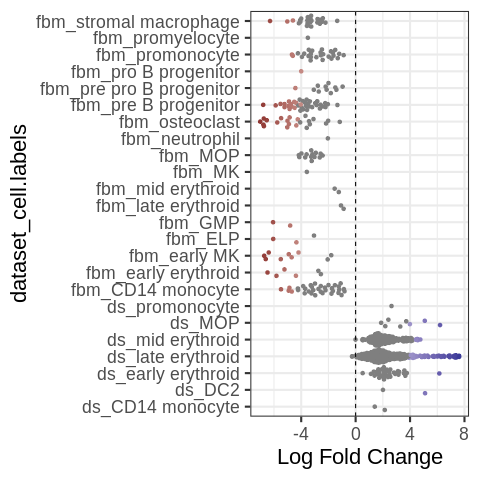

In [129]:
%%R
plotDAbeeswarm(DA_results, group.by="dataset_cell.labels", alpha=0.1,subset.nhoods=DA_results[['dataset_cell.labels_fraction']] > 0.6) +
geom_hline(yintercept=0, linetype=2, color="black")

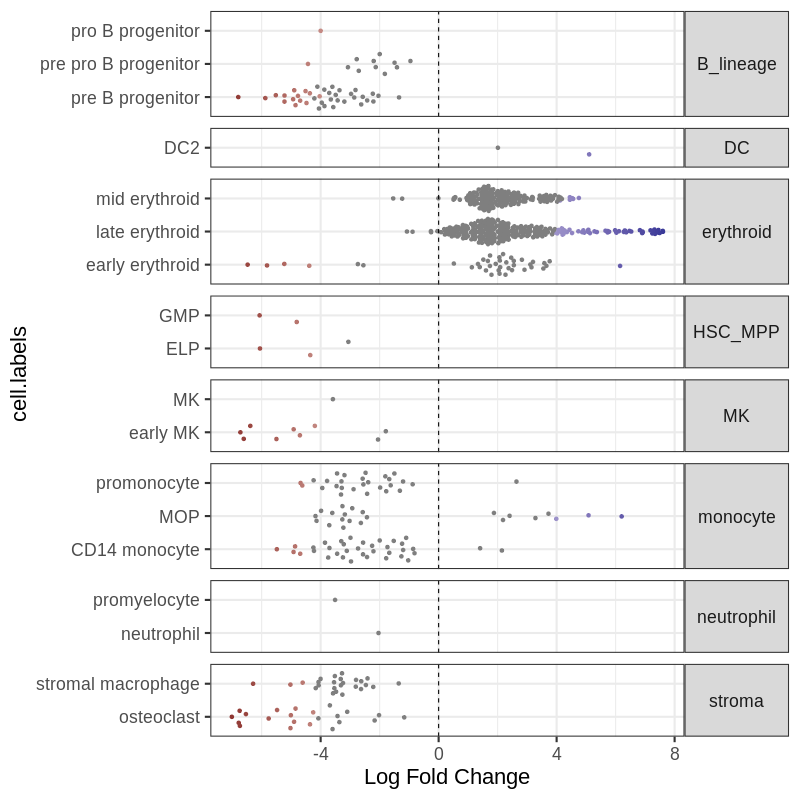

In [130]:
%%R -h 800 -w 800
library(tidyr)
DA_results %>%
    separate(dataset_cell.labels, into=c("dataset", "cell.labels"), sep="_") %>%
    plotDAbeeswarm(group.by="cell.labels", subset.nhoods=DA_results[['dataset_cell.labels_fraction']] > 0.6) +
    geom_hline(yintercept=0, linetype=2, color="black") +
    facet_grid(broad_cell.labels~., scales="free", space="free") 

    

Without filtering of uniform neighbourhoods:

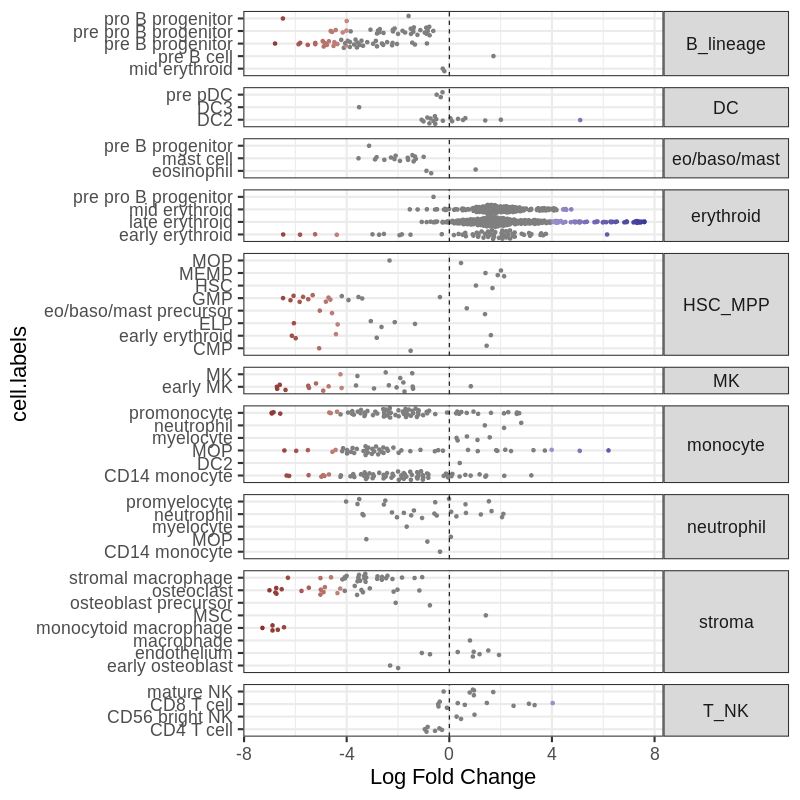

In [131]:
%%R -h 800 -w 800
library(tidyr)
DA_results %>%
    separate(dataset_cell.labels, into=c("dataset", "cell.labels"), sep="_") %>%
    plotDAbeeswarm(group.by="cell.labels") +
    geom_hline(yintercept=0, linetype=2, color="black") +
    facet_grid(broad_cell.labels~., scales="free", space="free") 
